,BOROUGH,GSS_CODE,HECTARES,LB_GSS_CD,NAME,NONLD_AREA,POLY_ID,geometry
0,Kingston upon Thames,E05000405,755.173,E09000021,Chessington South,0.0,50840,"POLYGON ((-0.329102847806278 51.3284831753942,..."
1,Kingston upon Thames,E05000414,259.464,E09000021,Tolworth and Hook Rise,0.0,117160,POLYGON ((-0.306876640848513 51.37533803905274...
2,Kingston upon Thames,E05000401,145.390,E09000021,Berrylands,0.0,50449,POLYGON ((-0.3022678683218721 51.3919660752230...
3,Kingston upon Thames,E05000400,268.506,E09000021,Alexandra,0.0,50456,POLYGON ((-0.2683146163290724 51.3879292853919...
4,Kingston upon Thames,E05000402,187.821,E09000021,Beverley,0.0,117161,POLYGON ((-0.2450334388319993 51.3986908549904...


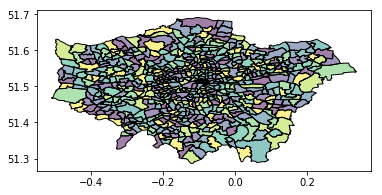

In [2]:
%matplotlib inline
import geopandas as gpd
from shapely.geometry import *

### data is from: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london 
london = gpd.read_file('../data/London_Ward.shp')
### from the prj file: http://www.prj2epsg.org/epsg/27700
london = london.to_crs({'init': 'epsg:4277'})  
london.plot()
london.head()

In [4]:
import sys
import numpy as np
import datetime
import numpy as np
import geojson
from scipy import stats

### path to data
venues = "../../../raw_data/venues/London_venues.txt"
transitions = "../../../raw_data/transitions/London_transitions.txt"

### venue ID -> coordinates for that venue
venue_id_to_coords = {}
with open(venues, 'r') as f:
    for rows in f:
        rows = rows.split("\t")
        ID = rows[0]
        coordinates = (float(rows[2]), float(rows[3]))
        venue_id_to_coords[ID] = coordinates

### venue ID -> ward that venue is in
venue_id_to_ward = {}
for venue in venue_id_to_coords: 
    coordinates = venue_id_to_coords[venue]
    latitude, longitude = coordinates
    point_of_checkin = Point(longitude, latitude) 
    
    does_contain_point = london.contains(point_of_checkin) 
    contains = does_contain_point[does_contain_point == True]     
    if len(contains) > 0:
        ward = contains.index[0] 
        venue_id_to_ward[venue] = ward

In [5]:
### create a map of venue (specifically, their ID) 
### to a list of *arrival* times to that venue       
venue_id_to_times = {}
with open(transitions, 'r') as f:
    for rows in f:
        rows = rows.split("\t")
        location1 = rows[0]
        time1 = rows[1]
        location2 = rows[2]
        time2 = rows[3]
        if location1 in venue_id_to_coords and location2 in venue_id_to_coords: 
            timeTravelled = int(time2) - int(time1)
            if timeTravelled > 0:
                # km / hrs
                timeTravelled = (timeTravelled / 60.0)/ 60.0 
                venue_id_to_times.setdefault(location1, [])
                time_cleaned = datetime.datetime.fromtimestamp(int(time1))
                venue_id_to_times[location1].append(time_cleaned)

In [6]:
### hour -> ward -> count 
hour_to_ward_to_count = {}

for x in range(0,24): 
    hour_to_ward_to_count[x] = {}

### for each venue, figure out which ward that venue    
### belongs to and keep track of the numb of checkins into that ward  
for venue_id in venue_id_to_times:
    checkins_to_a_venue = venue_id_to_times[venue_id]
    for checks in checkins_to_a_venue:
        # for now, we'll only look at weekdays 
        if checks.weekday() != 5 and checks.weekday() != 6:  
            if venue_id in venue_id_to_ward:
                ward = venue_id_to_ward[venue_id] 
                inner = hour_to_ward_to_count[checks.hour]
                inner.setdefault(ward, 0)
                inner[ward] += 1
                hour_to_ward_to_count[checks.hour] = inner

In [7]:
# we'll only look at wards that have at least 10 
# checkins during a given hour 
threshold_num_checkins = 10

# hour to ward to count of checkins into that ward 
# at that hour IFF the numb of checkins is over the 
# min threshold (N = 10)
hour_to_ward_to_count_threshold = {}

for x in range(0,24): 
    hour_to_ward_to_count_threshold[x] = {}

for hour in hour_to_ward_to_count_threshold: 
    inner = hour_to_ward_to_count[hour]
    for ward in inner: 
        num_checkins = inner[ward]
        if num_checkins >= threshold_num_checkins:
            (hour_to_ward_to_count_threshold[hour])[ward] = num_checkins

In [16]:
import json
from django.contrib.gis.geos import GeometryCollection, GEOSGeometry

# we want to write our data to a geojson file 
# to do this, we'll create a dictionary representation 
# and then write that data stucture to a file 
geojson = {'type':'FeatureCollection', 'features':[]} 
i = 0
for hour in hour_to_ward_to_count_threshold: 
    inner = hour_to_ward_to_count_threshold[hour]
    for ward in inner:  
        feature = {'type':'Feature',
                    'properties':{},
                    'geometry':{'type':'Polygon',
                                'coordinates':[]}}
 
        count =  hour_to_ward_to_count_threshold[hour][ward]
        feature['properties']['mag'] = count
        feature['properties']['time'] = hour
        feature['properties']['name'] = london.ix[ward]['NAME']
        feature['geometry']['coordinates'] = [list((london.ix[ward])['geometry'].exterior.coords)]
        geojson['features'].append(feature) 
geojson_str = json.dumps(geojson)

In [15]:
london.ix[0]['NAME']

u'Chessington South'

In [17]:
f = open("london_wards_inflow_name.geojson", 'w')
f.write(geojson_str)
f.close()